# Data Preprocessing

In [ ]:
!pip install noisereduce
!pip install pedalboard
!pip install librosa

In [5]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import noisereduce as nr
from pedalboard import *
from scipy.io import wavfile



c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test Librosa

✅ Loaded: train_0001.wav | Samples: 99841 | Sample Rate: 16000
✅ Loaded: train_0002.wav | Samples: 71841 | Sample Rate: 16000
✅ Loaded: train_0003.wav | Samples: 62881 | Sample Rate: 16000


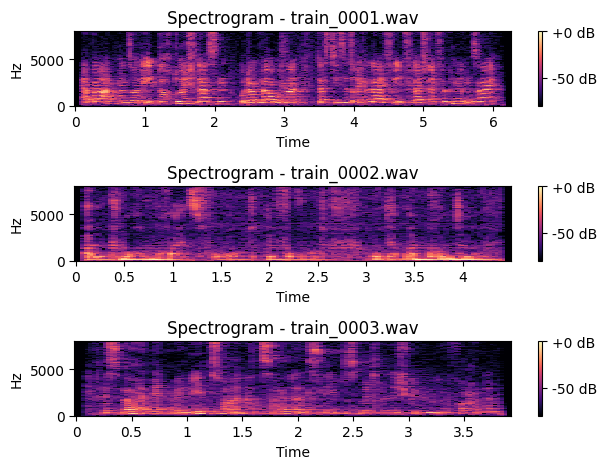

In [27]:
file_path = './ComParE2017_Cold_4students/wav/train_files'  # Path to your audio file
data_split = ['train', 'val', 'test']  # List of data splits
n = 3  # Number of files to load

wav_files = sorted([f for f in os.listdir(file_path) if f.endswith('.wav')])[:n]

audio_data = []  

for wav_file in wav_files:
    full_path = os.path.join(file_path, wav_file)  # Fix: don't add another 'train' directory
    y, sr = librosa.load(full_path, sr=None)
    audio_data.append((y, sr, wav_file))
    print(f"✅ Loaded: {wav_file} | Samples: {len(y)} | Sample Rate: {sr}")

for i, (y, sr, filename) in enumerate(audio_data):
    plt.subplot(n, 1, i + 1)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram - {filename}")

plt.tight_layout()
plt.savefig("spectrograms.png", dpi=300)
plt.show()

## Load Data

In [6]:
def load_audio_file(wav_file, path):
    full_path = os.path.join(file_path, path, wav_file)
    try:
        y, sr = librosa.load(full_path, sr=None)
        return (y, sr, wav_file)
    except Exception as e:
        print(f"❌ Error loading {wav_file}: {e}")
        return None

In [33]:
from tqdm import tqdm
import concurrent.futures

file_path = './ComParE2017_Cold_4students/wav/train_files' 

# Get list of wav files
wav_files = sorted([f for f in os.listdir(file_path) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
original_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, ""): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                original_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(original_data)} of {len(wav_files)} files")


📂 Loading processed set: 9505 files


Loading audio files: 100%|██████████| 9505/9505 [00:03<00:00, 2761.32it/s]

✅ Successfully loaded 9505 of 9505 files


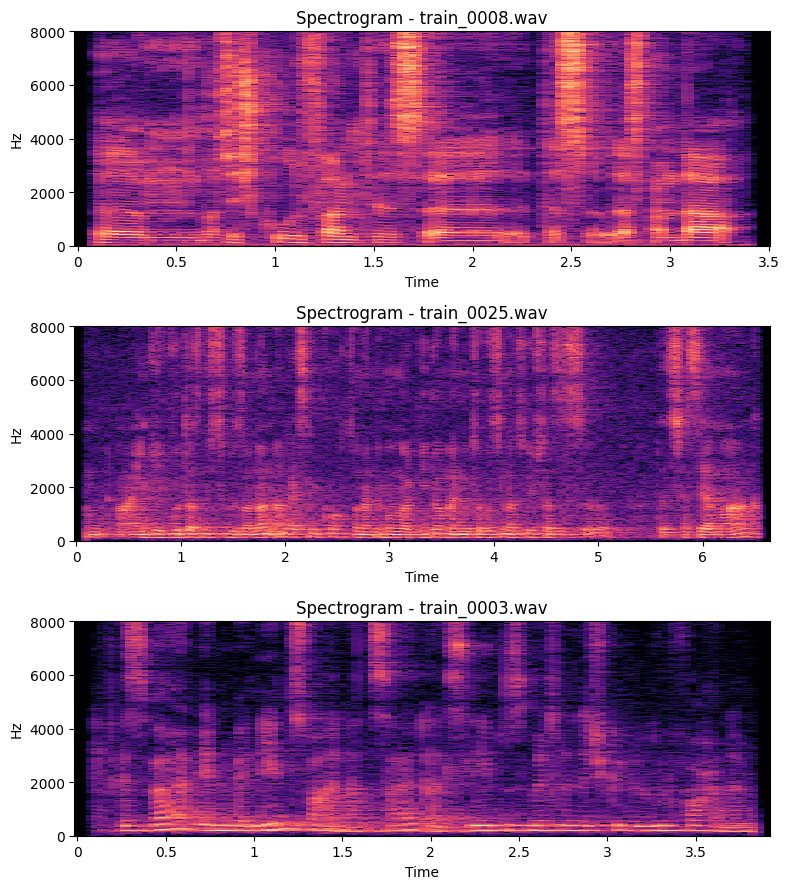

In [36]:
n = 3

plt.figure(figsize=(8, 3 * n))

for i, filename in enumerate(original_data[:n]):
    y, sr = librosa.load(os.path.join(file_path, filename), sr=None)
    ax = plt.subplot(n, 1, i + 1)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(
        S_db, sr=sr, x_axis='time', y_axis='hz', ax=ax
    )
    ax.set_title(f"Spectrogram - {filename}")

plt.tight_layout()
plt.savefig("spectrograms_first3.png", dpi=300)
plt.show()

## Denoising

In [44]:
save_path = os.path.join(file_path, 'denoised_enhanced_train')
os.makedirs(save_path, exist_ok=True)

# If original_data is a list of filenames:
for filename in tqdm(original_data, desc="Denoising & Enhancing", unit="file"):
    # Load
    y, sr = librosa.load(os.path.join(file_path, filename), sr=None)

    # Noise reduction
    reduced_noise = nr.reduce_noise(
        y=y, sr=sr, stationary=True,
        prop_decrease=0.82,
        time_mask_smooth_ms=50,
        freq_mask_smooth_hz=100
    )

    # Pedalboard enhancement
    board = Pedalboard([
        NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
        Compressor(threshold_db=-16, ratio=4),
        LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
        Gain(gain_db=2)
    ])
    effected = board(reduced_noise, sr)

    # Save
    output_path = os.path.join(save_path, filename)
    wavfile.write(output_path, sr, (effected * 32767).astype(np.int16))

print(f"✅ Saved: {len(original_data)} processed files to {save_path}")

Denoising & Enhancing: 100%|██████████| 9505/9505 [09:26<00:00, 16.77file/s]

✅ Saved: 9505 processed files to ./ComParE2017_Cold_4students/wav/train_files\denoised_enhanced_train


In [37]:
import concurrent.futures
from tqdm import tqdm

file_path = './ComParE2017_Cold_4students/wav/train_files'  

def process_audio_file(filename, file_path):

    # Load the audio file
    y, sr = librosa.load(os.path.join(file_path, filename), sr=None)
    
    # Noise reduction
    reduced_noise = nr.reduce_noise(
        y=y, sr=sr, stationary=True, 
        prop_decrease=0.85,
        time_mask_smooth_ms=50,      # Smoother time mask
        freq_mask_smooth_hz=100      # Smoother frequency mask
    )
    
    # Enhancing through pedalboard
    board = Pedalboard([
        NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
        Compressor(threshold_db=-16, ratio=4),
        LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
        Gain(gain_db=2)
    ])
    effected = board(reduced_noise, sr)
    
    # Save the processed audio
    save_path = os.path.join(file_path, 'denoised_enhanced_train')
    os.makedirs(save_path, exist_ok=True)
    output_path = os.path.join(save_path, filename)
    wavfile.write(output_path, sr, (effected * 32767).astype(np.int16))
    
    return filename

# Create save directory if it doesn't exist
save_path = os.path.join(file_path, 'denoised_enhanced_train')
os.makedirs(save_path, exist_ok=True)

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(process_audio_file, filename, file_path): filename 
                     for filename in original_data}
    
    # Process results as they complete with progress bar
    denoised_audio_data = []
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Denoising audio files"):
        filename = future_to_file[future]
        try:
            processed_file = future.result()
            denoised_audio_data.append(processed_file)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print(f"✅ Saved: {len(denoised_audio_data)} of {len(original_data)} processed files to {save_path}")

Denoising audio files: 100%|██████████| 9505/9505 [00:00<00:00, 25875.26it/s]

Error processing train_0008.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0025.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0003.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0050.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0041.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0056.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0024.wav: A process in the process pool was terminated abruptly while the future was running or pending.
Error processing train_0015.wav: A process in the process pool was terminated abruptly while the future 

Visualization

In [45]:
file_path = './ComParE2017_Cold_4students/wav/train_files' 

folder_path = 'denoised_enhanced_train'
# Get list of wav files
wav_files = sorted([f for f in os.listdir(os.path.join(file_path, folder_path)) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
denoised_audio_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, folder_path): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                denoised_audio_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(denoised_audio_data)} of {len(wav_files)} files")


📂 Loading processed set: 9505 files


Loading audio files: 100%|██████████| 9505/9505 [00:06<00:00, 1531.50it/s]

✅ Successfully loaded 9505 of 9505 files


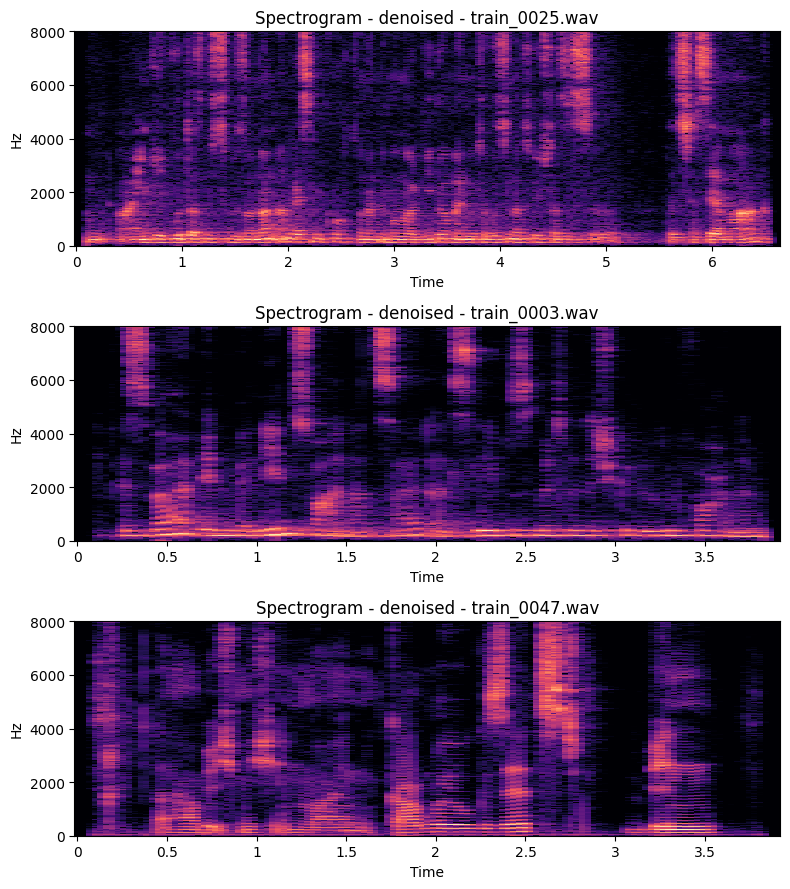

In [46]:
n = 3
plt.figure(figsize=(8, 3 * n))

for i, filename in enumerate(denoised_audio_data[:n]):
    y, sr = librosa.load(os.path.join('./ComParE2017_Cold_4students/wav/train_files/denoised_enhanced_train', filename), sr=None)
    ax = plt.subplot(n, 1, i + 1)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(
        S_db, sr=sr, x_axis='time', y_axis='hz', ax=ax
    )
    ax.set_title(f"Spectrogram - denoised - {filename}")

plt.tight_layout()
plt.show()

### Constrast

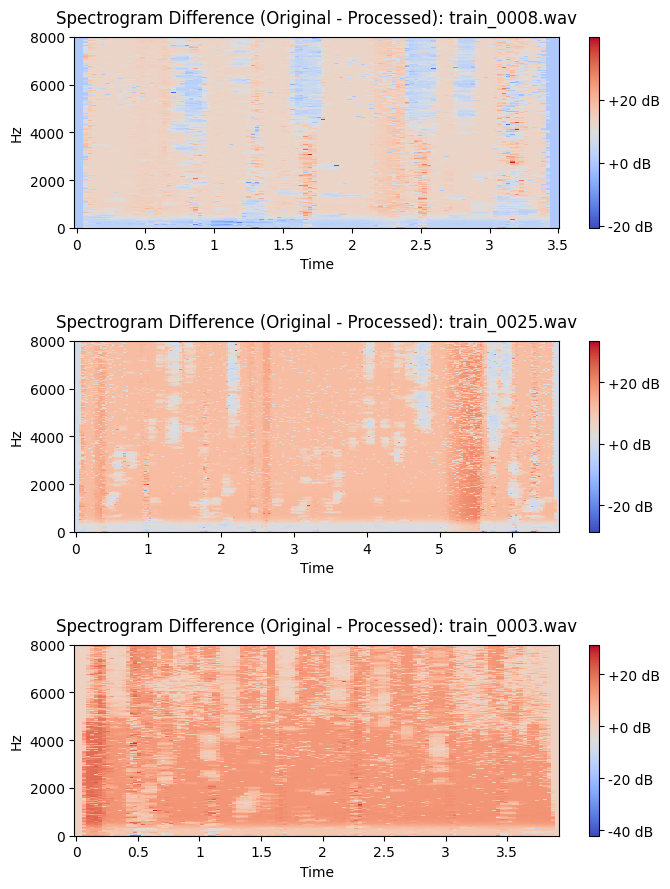

In [52]:
# plotting the original and processed audio and heatmap
n = 3
fig, axes = plt.subplots(n, 1, figsize=(7, 3 * n))

for i, filename in enumerate(original_data[:n]):
    y_orig, sr_orig = librosa.load(os.path.join(file_path, filename), sr=None)
    # find file in denoised_enhanced_train with the same name
    for f in os.listdir(os.path.join(file_path, 'denoised_enhanced_train')):
        if f == filename:
            break
    y_proc, sr_proc= librosa.load(os.path.join(file_path, 'denoised_enhanced_train', filename), sr=None)

    S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    S_proc = librosa.amplitude_to_db(np.abs(librosa.stft(y_proc)), ref=np.max)

    min_shape = (
        min(S_orig.shape[0], S_proc.shape[0]),
        min(S_orig.shape[1], S_proc.shape[1])
    )
    S_orig = S_orig[:min_shape[0], :min_shape[1]]
    S_proc = S_proc[:min_shape[0], :min_shape[1]]

    diff = S_orig - S_proc

    img = librosa.display.specshow(diff, sr=sr_orig, x_axis='time', y_axis='hz', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f"Spectrogram Difference (Original - Processed): {filename}", pad=10)
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

plt.tight_layout(h_pad=3.0)
plt.savefig("spectrogram_difference_heatmap.png", dpi=300)
plt.show()



## Pre-Emphasis Filter

y[n]=x[n]−α⋅x[n−1]

In [ ]:
file_path = './ComParE2017_Cold_4students/wav/train_files' 

folder_path = 'denoised_enhanced_train'
# Get list of wav files
wav_files = sorted([f for f in os.listdir(os.path.join(file_path, folder_path)) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
denoised_audio_data = []
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, folder_path): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                denoised_audio_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(denoised_audio_data)} of {len(wav_files)} files")

In [ ]:
def pre_emphasis(signal, alpha=0.85):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

save_path = os.path.join(file_path, 'e_filtered_train')
os.makedirs(save_path, exist_ok=True)

for filename in tqdm(denoised_audio_data, desc="Pre-emphasis", unit="file"):
    y, sr = librosa.load(os.path.join(file_path, folder_path, filename), sr=None)
    # Apply pre-emphasis filter
    pre_emphasized_audio = pre_emphasis(y)
    # Save the processed audio
    output_path = os.path.join(save_path, filename)
    wavfile.write(output_path, sr, (pre_emphasized_audio * 32767).astype(np.int16))
    

print(f"✅ Saved: {len(denoised_audio_data)} processed files to {save_path}")

Pre-emphasis: 100%|██████████| 9505/9505 [00:22<00:00, 426.30file/s]

✅ Saved: 9505 processed files to ./ComParE2017_Cold_4students/wav/train_files\e_filtered_train


### Contrast

In [ ]:
e_filtered_audio_data = []

file_path = './ComParE2017_Cold_4students/wav/train_files' 

folder_path = 'e_filtered_train'
# Get list of wav files
wav_files = sorted([f for f in os.listdir(os.path.join(file_path, folder_path)) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, folder_path): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                e_filtered_audio_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(e_filtered_audio_data)} of {len(wav_files)} files")


📂 Loading processed set: 9505 files


Loading audio files: 100%|██████████| 9505/9505 [00:06<00:00, 1518.89it/s]

✅ Successfully loaded 9505 of 9505 files


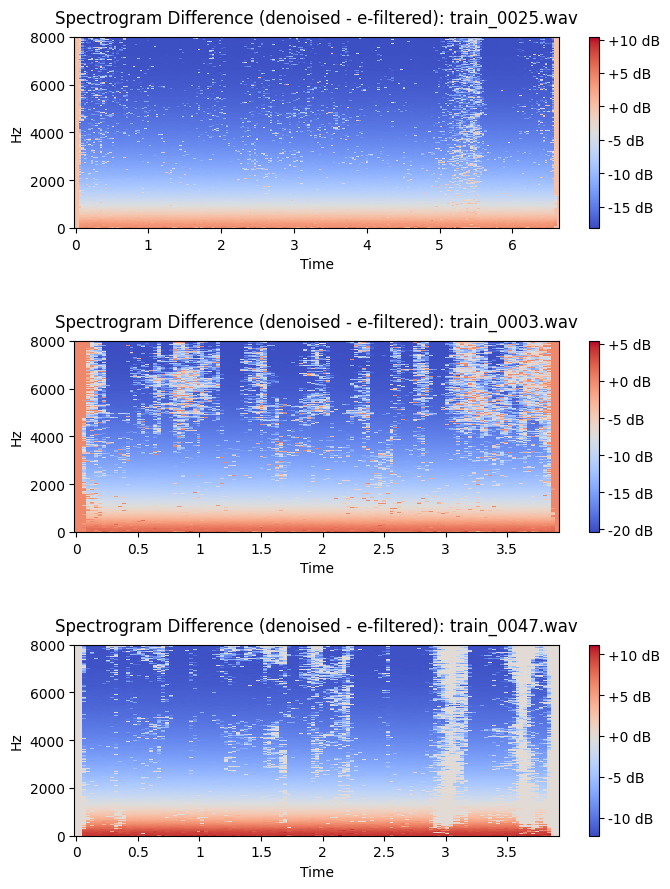

In [57]:
# plotting the original and processed audio and heatmap
n = 3

denoised_folder = 'denoised_enhanced_train'
e_filtered_folder = 'e_filtered_train'

fig, axes = plt.subplots(n, 1, figsize=(7, 3 * n))

for i, filename in enumerate(denoised_audio_data[:n]):
    y_orig, sr_orig = librosa.load(os.path.join(file_path, denoised_folder, filename), sr=None)
    # find file in denoised_enhanced_train with the same name
    for f in os.listdir(os.path.join(file_path, e_filtered_folder)):
        if f == filename:
            break
    y_proc, sr_proc= librosa.load(os.path.join(file_path, e_filtered_folder, filename), sr=None)

    S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    S_proc = librosa.amplitude_to_db(np.abs(librosa.stft(y_proc)), ref=np.max)

    min_shape = (
        min(S_orig.shape[0], S_proc.shape[0]),
        min(S_orig.shape[1], S_proc.shape[1])
    )
    S_orig = S_orig[:min_shape[0], :min_shape[1]]
    S_proc = S_proc[:min_shape[0], :min_shape[1]]

    diff = S_orig - S_proc

    img = librosa.display.specshow(diff, sr=sr_orig, x_axis='time', y_axis='hz', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f"Spectrogram Difference (denoised - e-filtered): {filename}", pad=10)
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

plt.tight_layout(h_pad=3.0)
plt.savefig("spectrogram_difference_heatmap.png", dpi=300)
plt.show()


## Loudness Normalization

In [4]:
!pip install pyloudnorm

  Using cached pyloudnorm-0.1.1-py3-none-any.whl.metadata (5.6 kB)
Using cached pyloudnorm-0.1.1-py3-none-any.whl (9.6 kB)


Load Denoised Data

In [ ]:
import pyloudnorm as pyln       

target_loudness=-23.0
for split in data_split:
    for y, sr, filename in denoised_audio_data[split]:
        rate = sr
        data = y

        # measure the loudness first 
        meter = pyln.Meter(rate) 
        loudness = meter.integrated_loudness(data)

        # loudness normalize audio to -23 dB LUFS
        loudness_normalized_audio = pyln.normalize.loudness(data, loudness,  target_loudness)

        # Save the processed audio
        save_path = os.path.join(file_path, 'loudness_normalized_' + split)
        os.makedirs(save_path, exist_ok=True)
        output_path = os.path.join(save_path, filename.replace(".wav", "_loudness_normalized.wav"))
        wavfile.write(output_path, sr, (loudness_normalized_audio * 32767).astype(np.int16))
        print(f"✅ Saved: {output_path}")


✅ Saved: ppl_dataset/loudness_normalized_train\train_9493_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9494_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9496_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9497_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9498_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9499_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9500_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_train\train_9501_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_val\train_9495_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_val\train_9502_processed_loudness_normalized.wav
✅ Saved: ppl_dataset/loudness_normalized_val\train_9503_processed_loudness_normalize

In [60]:
loudness_normalized_audio = []
target_loudness = -28.0 
 # Save the processed audio

in_dir  = os.path.join(file_path, 'e_filtered_train')
out_dir = os.path.join(file_path, 'loudness_normalized_train')
save_path = os.path.join(file_path, 'loudness_normalized_train' )
os.makedirs(save_path, exist_ok=True)

for filename in tqdm(e_filtered_audio_data, desc="Loudness Normalization", unit="file"):
    y, sr = librosa.load(os.path.join(in_dir, filename), sr=None)

    # 2) measure & normalize to LUFS
    meter    = pyln.Meter(sr)
    loudness = meter.integrated_loudness(y)
    y_norm   = pyln.normalize.loudness(y, loudness, target_loudness)

    # 3) peak-normalize to avoid PCM clipping
    peak = np.max(np.abs(y_norm))
    if peak > 1.0:
        y_norm = y_norm / peak

    # 4) write the *correct* array
    output_path = os.path.join(out_dir, filename)
    wavfile.write(
        output_path,
        sr,
        (y_norm * 32767).astype(np.int16)
    )
print(f"✅ Saved: {len(loudness_normalized_audio)} processed files to {save_path}")

Loudness Normalization:   1%|▏         | 121/9505 [00:00<01:13, 128.47file/s]c:\Python312\Lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Loudness Normalization:   7%|▋         | 651/9505 [00:05<01:12, 122.73file/s]c:\Python312\Lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Loudness Normalization:  19%|█▉        | 1819/9505 [00:15<01:14, 102.82file/s]c:\Python312\Lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Loudness Normalization:  22%|██▏       | 2062/9505 [00:18<01:09, 107.50file/s]c:\Python312\Lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Loudness Normalization:  33%|███▎     

✅ Saved: 0 processed files to ./ComParE2017_Cold_4students/wav/train_files\loudness_normalized_train


### Constrast

In [61]:
normalized_audio_data = []

file_path = './ComParE2017_Cold_4students/wav/train_files' 

folder_path = 'loudness_normalized_train'
# Get list of wav files
wav_files = sorted([f for f in os.listdir(os.path.join(file_path, folder_path)) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, folder_path): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                normalized_audio_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(normalized_audio_data)} of {len(wav_files)} files")


📂 Loading processed set: 9505 files


Loading audio files: 100%|██████████| 9505/9505 [00:04<00:00, 1997.98it/s]

✅ Successfully loaded 9505 of 9505 files


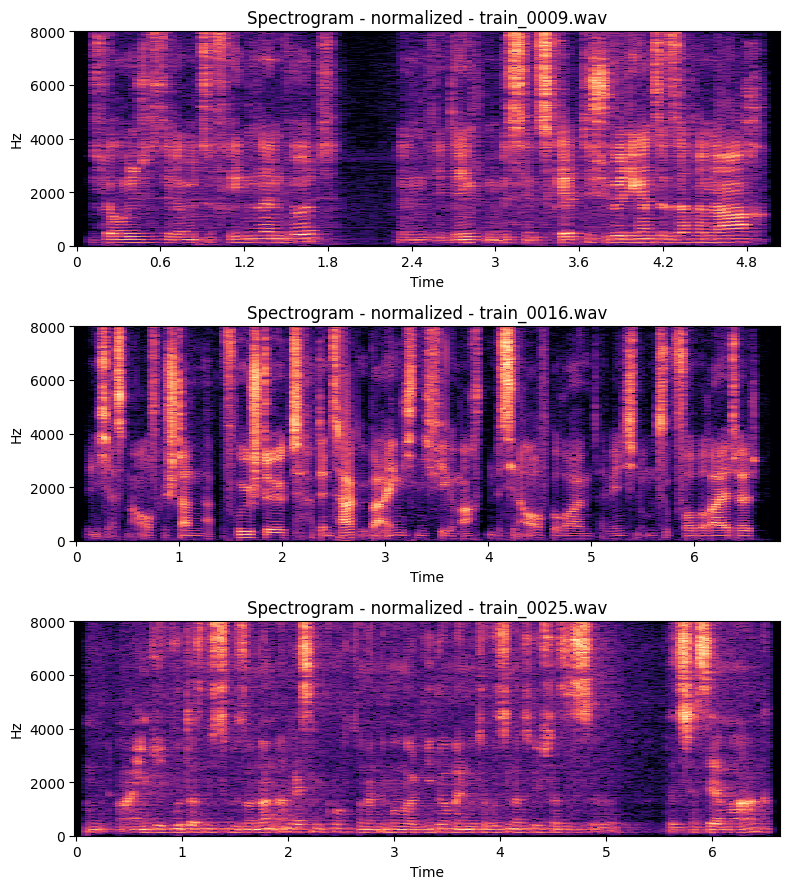

In [62]:
n = 3
plt.figure(figsize=(8, 3 * n))

for i, filename in enumerate(normalized_audio_data[:n]):
    y, sr = librosa.load(os.path.join(file_path, folder_path, filename), sr=None)
    ax = plt.subplot(n, 1, i + 1)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(
        S_db, sr=sr, x_axis='time', y_axis='hz', ax=ax
    )
    ax.set_title(f"Spectrogram - normalized - {filename}")

plt.tight_layout()
plt.show()

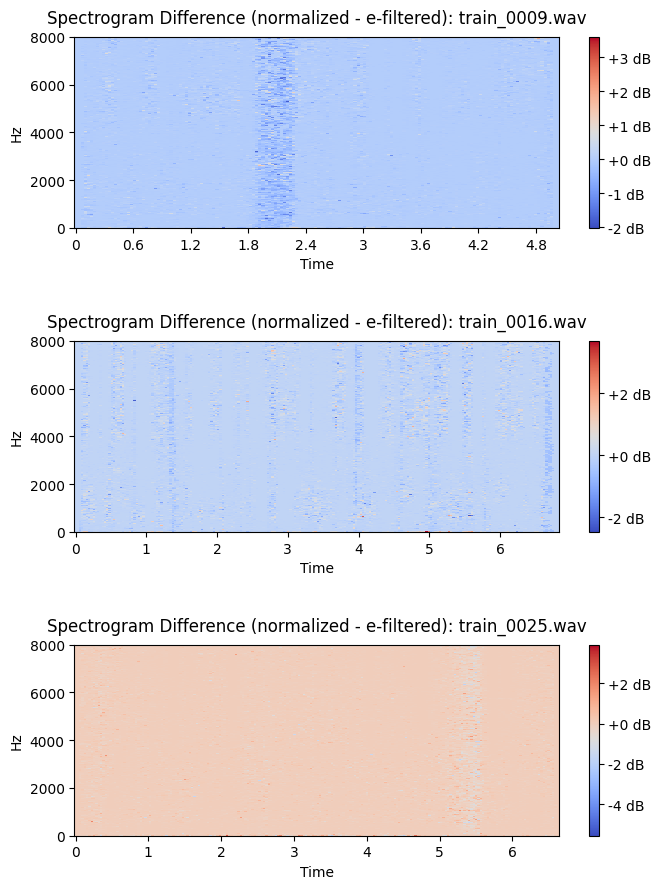

In [63]:
n = 3

denoised_folder = 'denoised_enhanced_train'
e_filtered_folder = 'e_filtered_train'
normalized_folder = 'loudness_normalized_train'

fig, axes = plt.subplots(n, 1, figsize=(7, 3 * n))

for i, filename in enumerate(normalized_audio_data[:n]):
    y_orig, sr_orig = librosa.load(os.path.join(file_path, normalized_folder, filename), sr=None)
    # find file in denoised_enhanced_train with the same name
    for f in os.listdir(os.path.join(file_path, e_filtered_folder)):
        if f == filename:
            break
    y_proc, sr_proc= librosa.load(os.path.join(file_path, e_filtered_folder, filename), sr=None)

    S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    S_proc = librosa.amplitude_to_db(np.abs(librosa.stft(y_proc)), ref=np.max)

    min_shape = (
        min(S_orig.shape[0], S_proc.shape[0]),
        min(S_orig.shape[1], S_proc.shape[1])
    )
    S_orig = S_orig[:min_shape[0], :min_shape[1]]
    S_proc = S_proc[:min_shape[0], :min_shape[1]]

    diff = S_orig - S_proc

    img = librosa.display.specshow(diff, sr=sr_orig, x_axis='time', y_axis='hz', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f"Spectrogram Difference (normalized - e-filtered): {filename}", pad=10)
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

plt.tight_layout(h_pad=3.0)
plt.savefig("spectrogram_difference_heatmap.png", dpi=300)
plt.show()

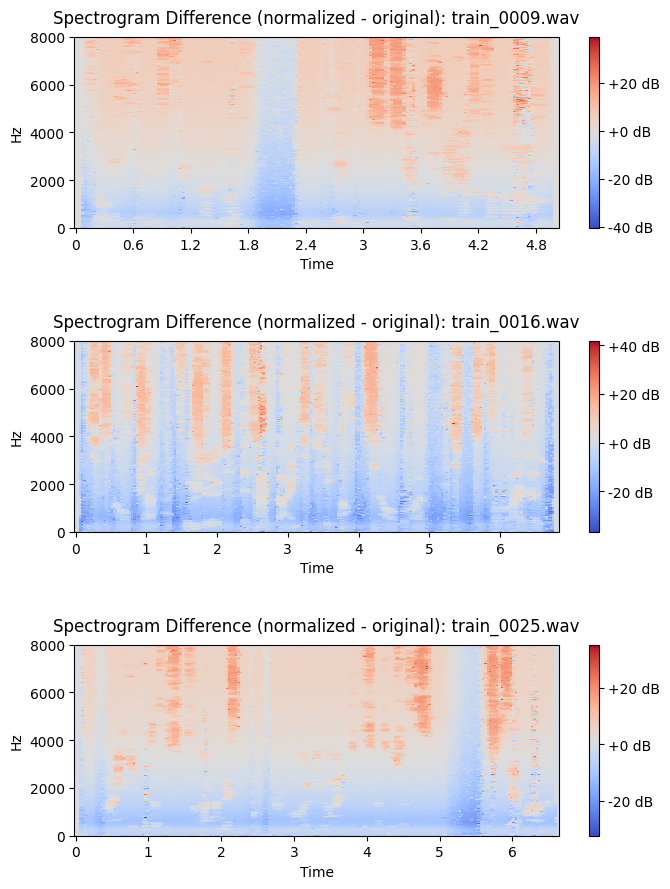

In [64]:
fig, axes = plt.subplots(n, 1, figsize=(7, 3 * n))

for i, filename in enumerate(normalized_audio_data[:n]):
    y_orig, sr_orig = librosa.load(os.path.join(file_path, normalized_folder, filename), sr=None)
    # find file in denoised_enhanced_train with the same name
    for f in os.listdir(file_path):
        if f == filename:
            break
    y_proc, sr_proc= librosa.load(os.path.join(file_path, filename), sr=None)

    S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    S_proc = librosa.amplitude_to_db(np.abs(librosa.stft(y_proc)), ref=np.max)

    min_shape = (
        min(S_orig.shape[0], S_proc.shape[0]),
        min(S_orig.shape[1], S_proc.shape[1])
    )
    S_orig = S_orig[:min_shape[0], :min_shape[1]]
    S_proc = S_proc[:min_shape[0], :min_shape[1]]

    diff = S_orig - S_proc

    img = librosa.display.specshow(diff, sr=sr_orig, x_axis='time', y_axis='hz', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f"Spectrogram Difference (normalized - original): {filename}", pad=10)
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

plt.tight_layout(h_pad=3.0)
plt.savefig("spectrogram_difference_heatmap.png", dpi=300)
plt.show()

## Clustering



In [7]:
from tqdm import tqdm
import concurrent.futures

final_data = []
file_path = './ComParE2017_Cold_4students/wav/train_files'
folder_path = 'loudness_normalized_train'
# Get list of wav files
wav_files = sorted([f for f in os.listdir(os.path.join(file_path, folder_path)) if f.endswith('.wav')])
print(f"\n📂 Loading processed set: {len(wav_files)} files")

# Number of workers (adjust based on your CPU)
max_workers = os.cpu_count() - 1 or 1  # Reserve one CPU core for system tasks

# Process files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks and get future objects
    future_to_file = {executor.submit(load_audio_file, wav_file, folder_path): wav_file 
                     for wav_file in wav_files}
    
    # Use tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(future_to_file), 
                      total=len(future_to_file),
                      desc="Loading audio files"):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                final_data.append(filename)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

print(f"✅ Successfully loaded {len(final_data)} of {len(wav_files)} files")


📂 Loading processed set: 9505 files


Loading audio files: 100%|██████████| 9505/9505 [00:07<00:00, 1263.21it/s]

✅ Successfully loaded 9505 of 9505 files


### Speech Brain Clustering


In [43]:
!pip install speechbrain


   ---------------------------------------- 0.0/864.1 kB ? eta -:--:--
   --------------------------------------- 864.1/864.1 kB 12.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/992.0 kB ? eta -:--:--
   ---------------------------------------- 992.0/992.0 kB 9.4 MB/s eta 0:00:00

   ---------------- ----------------------- 2/5 [ruamel.yaml]
   ---------------- ----------------------- 2/5 [ruamel.yaml]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   -------------------------------- ------- 4/5 [speechbrain]
   ------------

In [ ]:
import speechbrain as sb


### pyannote-audio + HDBSCAN

In [ ]:
!pip install pyannote-audio hdbscan


In [8]:
from pyannote.audio import Inference
import os
from dotenv import load_dotenv
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_dotenv()
token =  os.getenv("HUGGINGFACE_TOKEN")
inference = Inference("pyannote/embedding", 
                      use_auth_token=token).to(device)


# inference on the whole file
# wav_files = sorted([f for f in os.listdir(os.path.join(file_path, 'e_filtered_train')) if f.endswith('.wav')])



c:\Python312\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\10857\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.7.0+cu126. Bad things might happen unless you revert torch to 1.x.


c:\Python312\Lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


Test

In [9]:
e_filtered_folder = 'e_filtered_train'
print(f"Processing {final_data[0]}...")
full_path = os.path.join(file_path, e_filtered_folder, final_data[0])
embedding = inference(full_path) 

print(f"✅ Embedding: {embedding}")


Processing train_0002.wav...
✅ Embedding: <pyannote.core.feature.SlidingWindowFeature object at 0x000001B62D0181D0>


In [10]:
embedding_array = embedding.data  

mean_embedding = embedding_array.mean(axis=0) 
print(f"✅ Mean Embedding: {mean_embedding}")

✅ Mean Embedding: [-1.32327294e+00  3.47419815e+01  1.81432819e+01  3.68759499e+01
 -2.73643456e+01  4.14087181e+01 -1.99570417e+00  4.45347481e+01
  3.06321602e+01  4.13693275e+01  4.06572800e+01 -4.66378784e+01
 -6.90460873e+00 -6.08988609e+01 -8.81004028e+01 -3.70415878e+01
 -3.86941986e+01  5.45567780e+01  3.69337769e+01  6.26470423e+00
 -5.75248413e+01  4.59424248e+01  3.70208054e+01 -2.10720959e+01
 -2.54081154e+01 -7.60330124e+01  1.24129620e+01  4.04426956e+01
 -4.18994522e+00  3.77040443e+01  2.08851910e+00 -3.95828724e-01
  2.94719315e+01  5.02534790e+01  4.27681961e+01  2.80609760e+01
 -2.79495449e+01 -8.95589638e+00 -7.55728054e+00  1.18035803e+01
  2.44916267e+01 -2.12335052e+01 -4.43730659e+01 -3.47709427e+01
  5.16259003e+01 -4.03537674e+01  4.24975281e+01  3.30339966e+01
 -9.78841705e+01 -5.93509483e+01 -1.11448507e+01  1.52236204e+01
 -2.61994514e+01 -5.50186310e+01 -2.15562668e+01  1.60996552e+01
 -6.07207060e+00 -6.44532928e+01  5.52846336e+01 -9.44610894e-01
  7.110

Pipeline

In [10]:
embedding_dict = {}
e_filtered_folder = 'e_filtered_train'

for filename in tqdm(final_data, desc="Processing audio files for embeddings", unit="file"):
    full_path = os.path.join(file_path, e_filtered_folder, filename)
    embedding = inference(full_path) 
    embedding_dict[filename] = embedding.data.mean(axis=0) 
    # print(f"✅Finished Mean Embedding: {filename}")
print(f"✅ Processed {len(embedding_dict)} files for embeddings.")


Processing audio files for embeddings:   0%|          | 0/9505 [00:00<?, ?file/s]c:\Python312\Lib\site-packages\pyannote\audio\utils\reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
Processing audio files for embeddings: 100%|██████████| 9505/9505 [01:54<00:00, 82.88file/s]

✅ Processed 9505 files for embeddings.


In [11]:
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
import numpy as np

label_dict = {}
file_list = list(embedding_dict.keys())
X_raw = np.vstack([embedding_dict[f] for f in file_list])
n_components = min(len(X_raw), X_raw.shape[1], 4)
X_pca = PCA(n_components=n_components).fit_transform(X_raw)
clusterer = HDBSCAN(
    min_cluster_size=5,      # allow clusters down to 5 points
    min_samples=2,           # make it easier to join points
    cluster_selection_epsilon=0.3,  # bridge small gaps
    metric='euclidean'       # default, but you can try 'manhattan', etc.
)
labels = clusterer.fit_predict(X_pca)  
label_dict = {fname: label for fname, label in zip(file_list, labels)}
print(f"✅ Finished Clustering: {len(set(labels))} clusters found")

c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Finished Clustering: 3 clusters found


In [12]:
from collections import Counter
cnt = Counter(labels)
print("Cluster sizes (label:count):", dict(cnt))


Cluster sizes (label:count): {np.int64(1): 9470, np.int64(-1): 30, np.int64(0): 5}


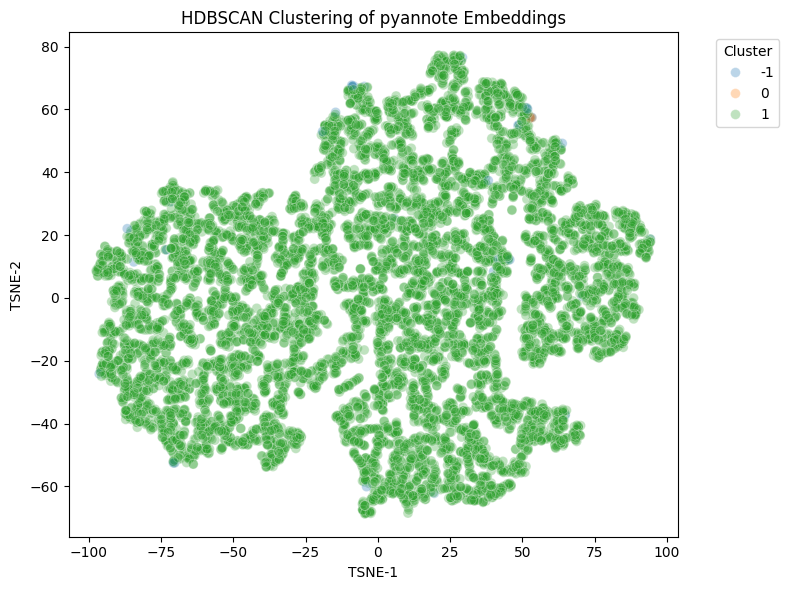

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42).fit_transform(X_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=labels,
    palette='tab10',
    s=50,      
    alpha=0.3  
)

plt.title("HDBSCAN Clustering of pyannote Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Kmeasn = 5

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels_km = kmeans.fit_predict(X_pca)


In [29]:
from collections import Counter

cnt_km = Counter(labels_km)
print("KMeans clusters (label: count):", dict(cnt_km))

label_km_dict = {fname: label for fname, label in zip(file_list, labels_km)}



KMeans clusters (label: count): {np.int32(1): 2895, np.int32(3): 1568, np.int32(4): 1858, np.int32(0): 1755, np.int32(2): 1429}


In [30]:
from collections import defaultdict

clusters = defaultdict(list)
for fname, lab in label_km_dict.items():
    clusters[lab].append(fname)

out_path = "clusters_5.txt"
with open(out_path, "w", encoding="utf-8") as f:
    for lab, files in sorted(clusters.items()):
        f.write(f"Cluster {lab} ({len(files)} files):\n")
        for fn in files:
            f.write(f"  {fn}\n")
        f.write("\n")

print(f"✅ Finish writing into {out_path}")

✅ Finish writing into clusters_5.txt


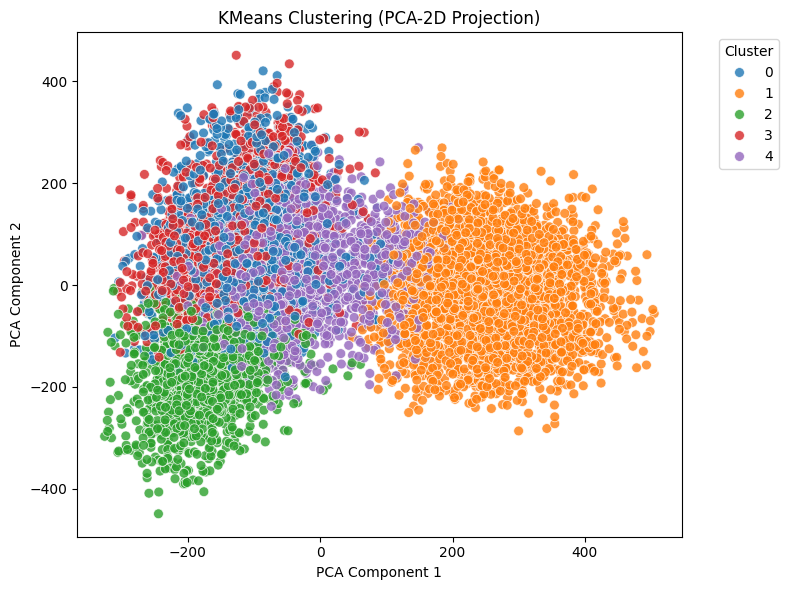

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (PCA-2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


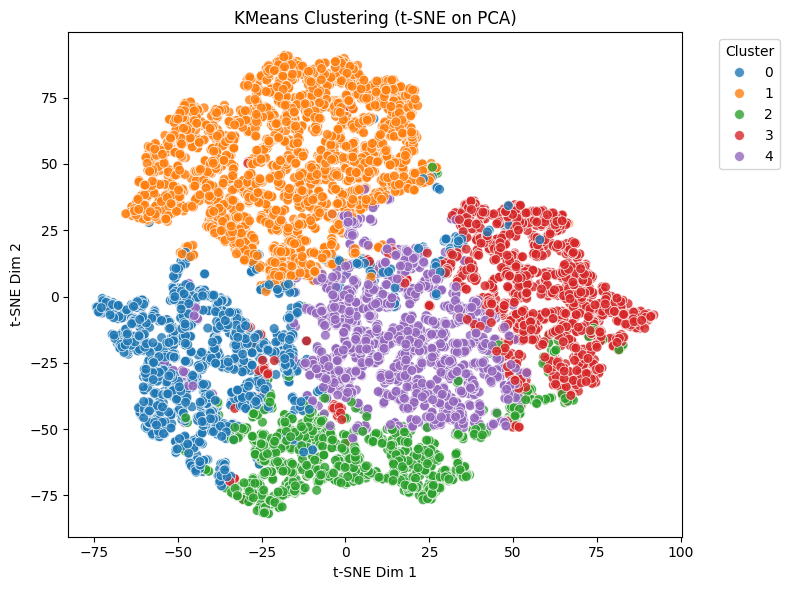

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_tsne_km = TSNE(n_components=2, perplexity=30, init='random', random_state=42) \
            .fit_transform(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_tsne_km[:,0],
    y=X_tsne_km[:,1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (t-SNE on PCA)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### kmeans = 8

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42)
labels_km = kmeans.fit_predict(X_pca)

from collections import Counter

cnt_km = Counter(labels_km)
print("KMeans clusters (label: count):", dict(cnt_km))

label_km_dict = {fname: label for fname, label in zip(file_list, labels_km)}

KMeans clusters (label: count): {np.int32(5): 1186, np.int32(2): 1165, np.int32(7): 1494, np.int32(6): 1436, np.int32(1): 1078, np.int32(3): 1183, np.int32(4): 1043, np.int32(0): 920}


In [27]:
from collections import defaultdict

clusters = defaultdict(list)
for fname, lab in label_km_dict.items():
    clusters[lab].append(fname)

out_path = "clusters_8.txt"
with open(out_path, "w", encoding="utf-8") as f:
    for lab, files in sorted(clusters.items()):
        f.write(f"Cluster {lab} ({len(files)} files):\n")
        for fn in files:
            f.write(f"  {fn}\n")
        f.write("\n")

print(f"✅ Finish writing into {out_path}")


✅ Finish writing into clusters_8.txt


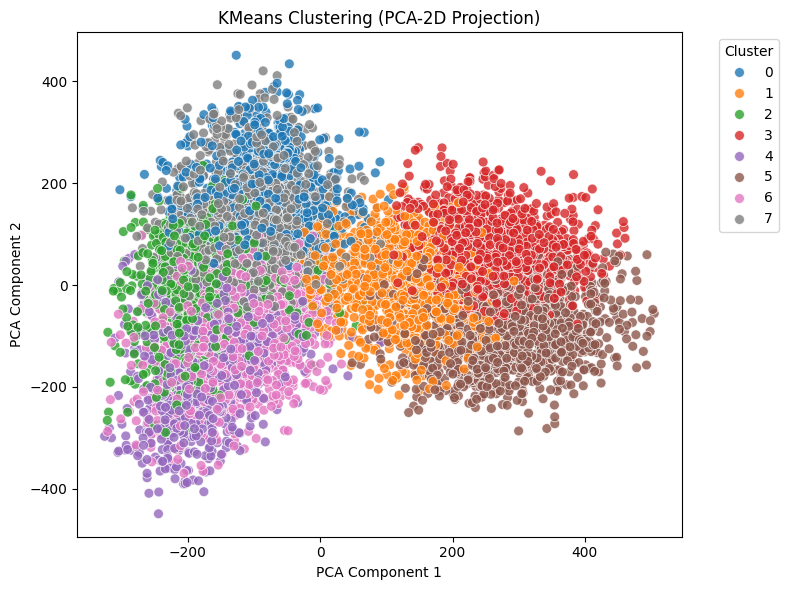

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (PCA-2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

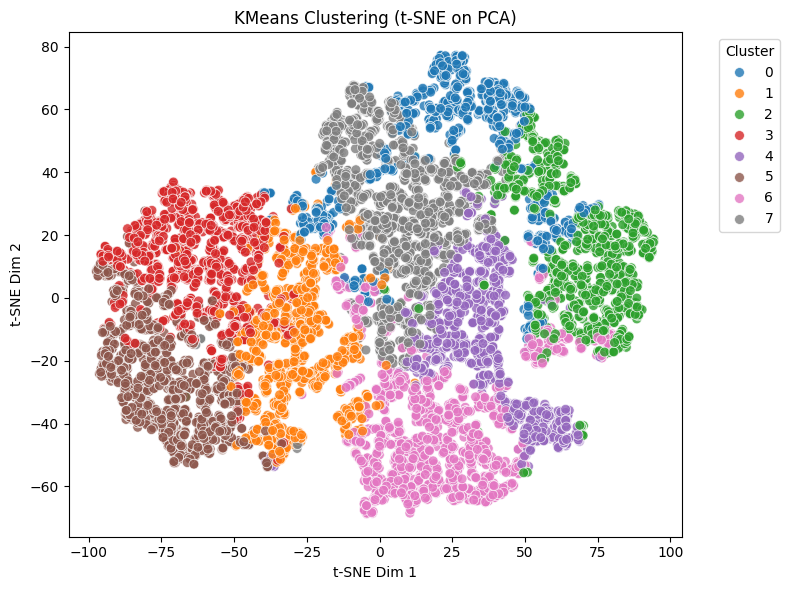

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_tsne_km = TSNE(n_components=2, perplexity=30, init='random', random_state=42) \
            .fit_transform(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_tsne_km[:,0],
    y=X_tsne_km[:,1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (t-SNE on PCA)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### kmeans = 10

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
labels_km = kmeans.fit_predict(X_pca)

from collections import Counter

cnt_km = Counter(labels_km)
print("KMeans clusters (label: count):", dict(cnt_km))

label_km_dict = {fname: label for fname, label in zip(file_list, labels_km)}

KMeans clusters (label: count): {np.int32(5): 817, np.int32(2): 1100, np.int32(7): 1099, np.int32(6): 1320, np.int32(9): 837, np.int32(3): 993, np.int32(4): 685, np.int32(1): 796, np.int32(0): 1084, np.int32(8): 774}


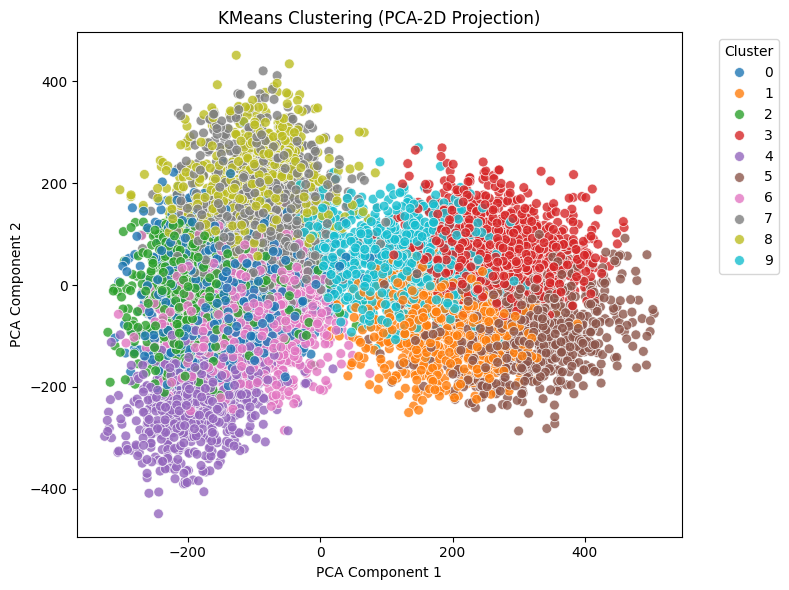

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (PCA-2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

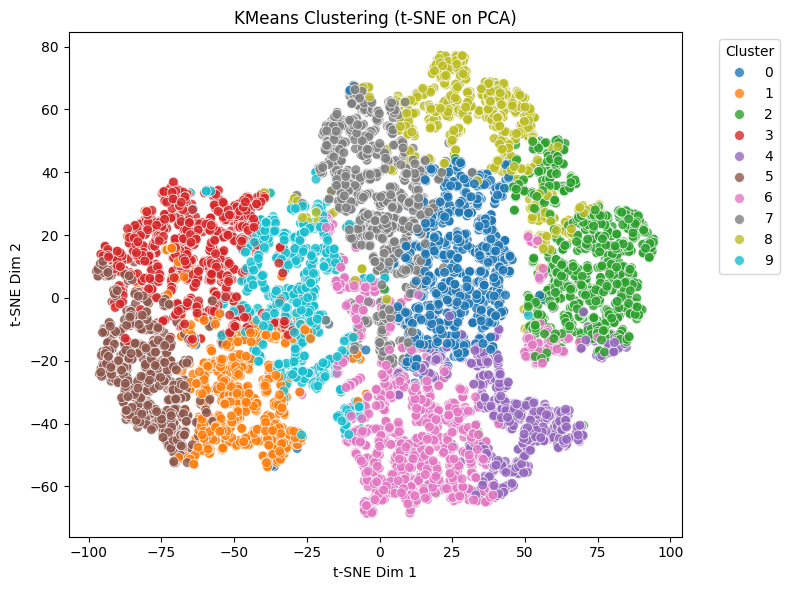

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_tsne_km = TSNE(n_components=2, perplexity=30, init='random', random_state=42) \
            .fit_transform(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_tsne_km[:,0],
    y=X_tsne_km[:,1],
    hue=labels_km,
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("KMeans Clustering (t-SNE on PCA)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
